# Glacier grids from SGI or GLAMOS:

Creates monthly grid files for the MBM to make PMB predictions over the whole glacier grid. The files come from the SGI grid and use OGGM topography. Computing takes a long time because of the conversion to monthly format.
## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import geopandas as gpd

# scripts
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.geodata import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()  # in case no memory

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
custom_working_dir = '../../../data/OGGM/'

In [3]:
# Climate columns
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
# Topographical columns
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]

### Read PMB data:

Note that the SGI shapefiles use a slightly different RGI number than OGGM and this is why we use `rgi_id_v6_2016_shp`.

In [4]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(glacier_list, gl_area)
glacier_list

Number of glaciers with pcsr: 31


['schwarzbach',
 'taelliboden',
 'pizol',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'tortin',
 'basodino',
 'limmern',
 'adler',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'oberaar',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'gorner',
 'aletsch']

In [5]:
# Cut the data to the glaciers that have pcsr data:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

In [6]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
rgi_df.head(2)

,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
short_name,,,,,,
adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [7]:
# Order glaciers per area:
shapefile_path = "../../../data/GLAMOS/topo/SGI2020/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)  # Load the shapefile

# Grid files
path_aspect = path_SGI_topo + 'aspect/'
path_slope = path_SGI_topo + 'slope/'
path_DEM = path_SGI_topo + 'dem_HR/'

gl_area = {}
for glacierName in rgi_df.index:
    if glacierName == 'clariden':
        sgi_id = rgi_df.loc['claridenL']['sgi-id'].strip()
        rgi_shp = rgi_df.loc['claridenL']['rgi_id_v6_2016_shp']
    else:
        sgi_id = rgi_df.loc[glacierName]['sgi-id'].strip()
        rgi_shp = rgi_df.loc[glacierName]['rgi_id_v6_2016_shp']

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(data_glamos.GLACIER.unique(), gl_area)
glacier_list

['schwarzbach',
 'taelliboden',
 'pizol',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'tortin',
 'basodino',
 'limmern',
 'adler',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'oberaar',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'gorner',
 'aletsch']

In [8]:
glacier_shp_rgi6 = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
glacier_outline_rgi = gpd.read_file(glacier_shp_rgi6)

# SGI (2015) grids:

## Examine SGI glacier masks over SGI aspect:
This is to check that there is a good overlap.

In [9]:
# Clear output folder
emptyfolder('figures/SGI_mask/')

for glacierName in tqdm(glacier_list, desc="Processing glaciers"):

    # Handle 'clariden' separately due to special ID format
    if glacierName == 'clariden':
        sgi_id = rgi_df.at[
            'claridenU',
            'sgi-id'].strip() if 'claridenU' in rgi_df.index else ''
        rgi_shp = rgi_df.at[
            'claridenU',
            'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
    else:
        sgi_id = rgi_df.at[
            glacierName,
            'sgi-id'].strip() if glacierName in rgi_df.index else ''
        rgi_shp = rgi_df.at[
            glacierName,
            'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

    # Skip if no SGI ID
    if not sgi_id:
        print(f'No SGI ID found for {glacierName}')
        continue

    # Get glacier mask
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]

    # Skip if no glacier mask found
    if gdf_mask_gl.empty:
        print(f'No glacier mask found for {glacierName}')
        continue

    # Locate aspect grid file
    path_aspect = os.path.join(path_SGI_topo, 'aspect')
    aspect_gl = next((f for f in os.listdir(path_aspect) if sgi_id in f), None)

    # Skip if no aspect file found
    if not aspect_gl:
        print(f'No aspect file found for {glacierName}')
        continue

    # Load grid file
    metadata_aspect, grid_data_aspect = load_grid_file(
        os.path.join(path_aspect, aspect_gl))

    # Convert to xarray
    aspect = convert_to_xarray_geodata(grid_data_aspect, metadata_aspect)

    # Transform to WGS84
    aspect_wgs84 = transform_xarray_coords_lv95_to_wgs84(aspect)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    aspect_wgs84.plot(ax=ax)
    gdf_mask_gl.plot(ax=ax, alpha=0.5)

    # Save the figure
    output_path = os.path.join('figures', 'SGI_mask', f"{glacierName}.png")
    plt.savefig(output_path, dpi=300)
    plt.close()


Processing glaciers:   0%|          | 0/31 [00:00<?, ?it/s]

#### Compare one example grid of SGI to OGGM:

Cell size of SGI: 10.00 x 10.00 meters
Cell size of OGGM: 66.00 x 66.00 meters


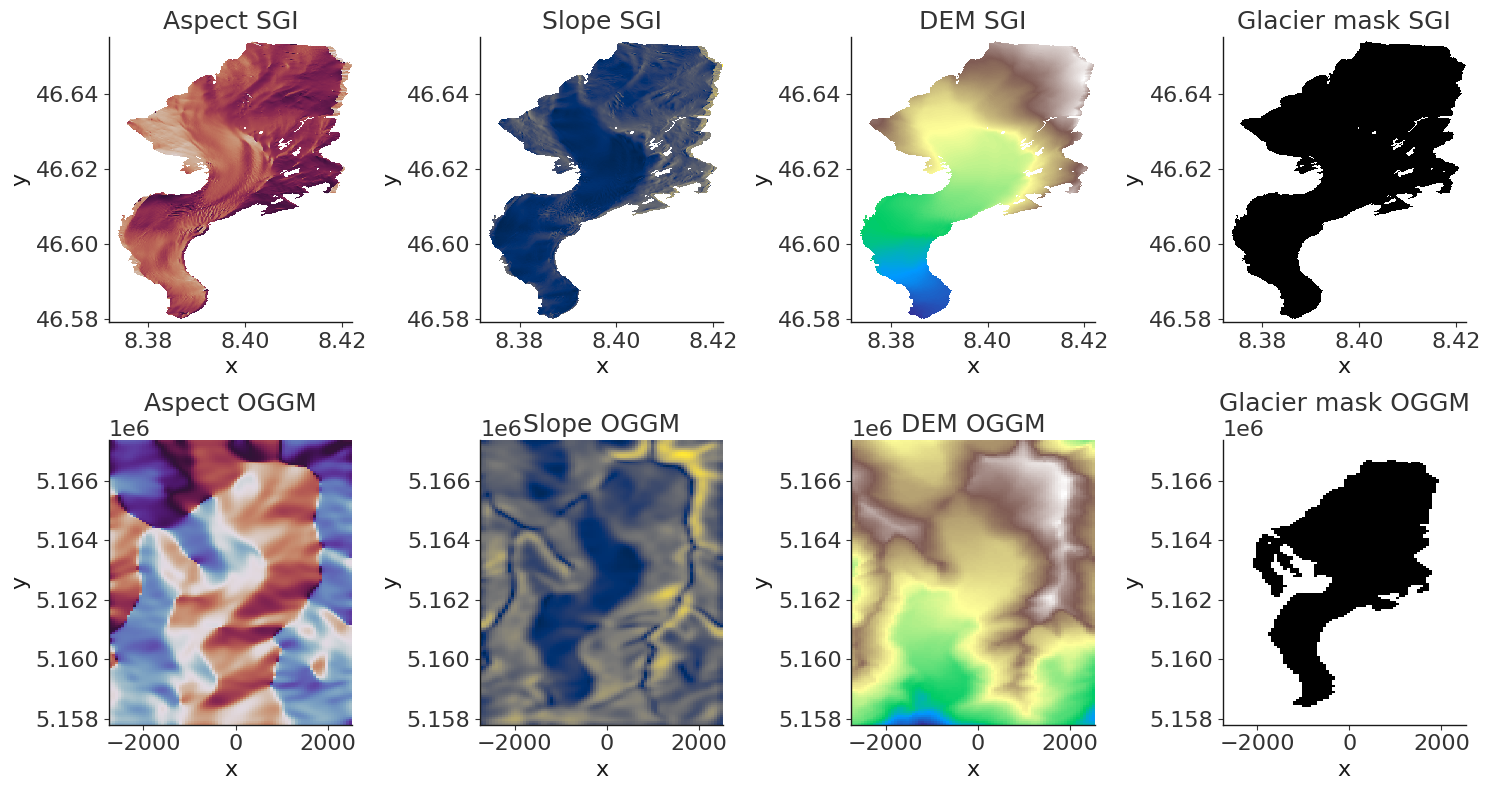

In [10]:
# Glacier name
glacierName = 'rhone'

# Get SGI ID and RGI shapefile ID safely
try:
    sgi_id = rgi_df.at[glacierName,
                       'sgi-id'].strip() if glacierName in rgi_df.index else ''
    rgi_id = rgi_df.at[glacierName,
                       'rgi_id.v6'] if glacierName in rgi_df.index else ''
    rgi_shp = rgi_df.at[
        glacierName,
        'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''
except KeyError:
    print(f"Error: {glacierName} not found in rgi_df")
    sgi_id, rgi_id, rgi_shp = '', '', ''

if not sgi_id or not rgi_id or not rgi_shp:
    print(f"Warning: Missing data for {glacierName}. Skipping...")
else:
    # Load SGI masked dataset
    ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect, path_slope,
                            path_DEM, sgi_id)

    if ds is None:
        print(
            f"Warning: Failed to load SGI dataset for {glacierName}. Skipping..."
        )
    else:
        # Load OGGM dataset
        oggm_path = os.path.join(path_OGGM, 'xr_grids', f'{rgi_id}.nc')

        try:
            ds_oggm = xr.open_dataset(oggm_path)
        except FileNotFoundError:
            print(
                f"Error: OGGM dataset not found for {glacierName}. Skipping..."
            )
            ds_oggm = None

        # Calculate SGI resolution
        dx_sgi = abs(ds.x[1] - ds.x[0])
        dy_sgi = abs(ds.y[1] - ds.y[0])
        print(f"Cell size of SGI: {dx_sgi:.2f} x {dy_sgi:.2f} meters")

        if ds_oggm is not None:
            # Calculate OGGM resolution
            dx_oggm = abs(ds_oggm.x[1] - ds_oggm.x[0])
            dy_oggm = abs(ds_oggm.y[1] - ds_oggm.y[0])
            print(f"Cell size of OGGM: {dx_oggm:.2f} x {dy_oggm:.2f} meters")

            # Plot the data
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))

            # SGI Data
            ds.masked_aspect.plot(ax=axs[0, 0],
                                  cmap='twilight_shifted',
                                  add_colorbar=False)
            ds.masked_slope.plot(ax=axs[0, 1],
                                 cmap='cividis',
                                 add_colorbar=False)
            ds.masked_elev.plot(ax=axs[0, 2],
                                cmap='terrain',
                                add_colorbar=False)
            ds.glacier_mask.plot(ax=axs[0, 3],
                                 cmap='binary',
                                 add_colorbar=False)

            axs[0, 0].set_title("Aspect SGI")
            axs[0, 1].set_title("Slope SGI")
            axs[0, 2].set_title("DEM SGI")
            axs[0, 3].set_title("Glacier mask SGI")

            # OGGM Data
            if all(var in ds_oggm
                   for var in ['aspect', 'slope', 'topo', 'glacier_mask']):
                ds_oggm.aspect.plot(ax=axs[1, 0],
                                    cmap='twilight_shifted',
                                    add_colorbar=False)
                ds_oggm.slope.plot(ax=axs[1, 1],
                                   cmap='cividis',
                                   add_colorbar=False)
                ds_oggm.topo.plot(ax=axs[1, 2],
                                  cmap='terrain',
                                  add_colorbar=False)
                ds_oggm.glacier_mask.plot(ax=axs[1, 3],
                                          cmap='binary',
                                          add_colorbar=False)

                axs[1, 0].set_title("Aspect OGGM")
                axs[1, 1].set_title("Slope OGGM")
                axs[1, 2].set_title("DEM OGGM")
                axs[1, 3].set_title("Glacier mask OGGM")
            else:
                print(
                    f"Warning: Some OGGM variables are missing in {oggm_path}")

            # Set axis labels
            for ax in axs.flatten():
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                ax.legend().remove()

            # Optimize layout
            plt.tight_layout()
            plt.show()

Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(30.) x <xarray.DataArray 'y' ()> Size: 8B
array(30.) meters


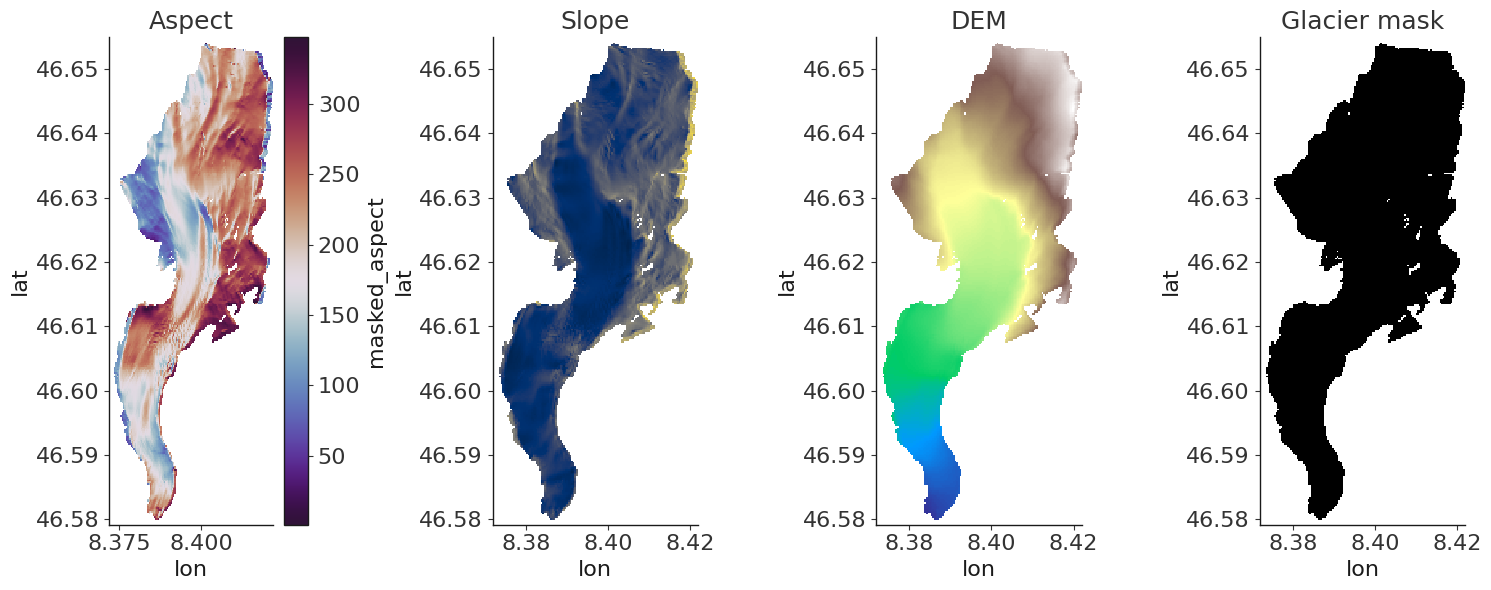

In [11]:
# Resample SGI grid:
# Coarson to 30 m resolution
ds_resampled = coarsenDS(ds)

# Calculate resolution
dx = abs(ds_resampled.x[1] - ds_resampled.x[0])
dy = abs(ds_resampled.y[1] - ds_resampled.y[0])
print(f"Cell size: {dx} x {dy} meters")

# Plot resampled grid
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_resampled.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_resampled.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds_resampled.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds_resampled.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

## Yearly masked grids - xarrays:
Save an .nc file per glacier per year (not in monthly format) needed in the MBM later.

In [14]:
# Define save path and ensure it exists
path_save = os.path.join(path_SGI_topo, 'xr_masked_grids/')
emptyfolder(path_save)

for glacierName in tqdm(glacier_list, desc="Processing glaciers"):
    print(f"\nProcessing {glacierName}...")

    # Handle 'clariden' separately due to special ID format
    if glacierName == 'clariden':
        sgi_id = rgi_df.at[
            'claridenU',
            'sgi-id'].strip() if 'claridenU' in rgi_df.index else ''
        rgi_shp = rgi_df.at[
            'claridenU',
            'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
    else:
        sgi_id = rgi_df.at[
            glacierName,
            'sgi-id'].strip() if glacierName in rgi_df.index else ''
        rgi_shp = rgi_df.at[
            glacierName,
            'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

    # Skip glacier if required data is missing
    if not sgi_id or not rgi_shp:
        print(
            f"Warning: Missing SGI ID or shapefile for {glacierName}. Skipping..."
        )
        continue

    # Load dataset
    try:
        ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect,
                                path_slope, path_DEM, sgi_id)
        if ds is None:
            print(
                f"Warning: Failed to load dataset for {glacierName}. Skipping..."
            )
            continue
    except Exception as e:
        print(f"Error loading dataset for {glacierName}: {e}")
        continue

    # Coarsen dataset to 30m resolution
    try:
        ds_resampled = coarsenDS(ds)
        if ds_resampled is None:
            print(f"Warning: Resampling failed for {glacierName}. Skipping...")
            continue
    except Exception as e:
        print(f"Error during resampling for {glacierName}: {e}")
        continue

    # Save dataset
    save_path = os.path.join(path_save, f"{glacierName}.nc")
    try:
        
        # Define a compression configuration for all data variables
        compression = dict(zlib=True, complevel=5)
        encoding = {var: compression for var in ds_resampled.data_vars}
        
        ds_resampled.to_netcdf(save_path, encoding = encoding)
        print(f"Saved {glacierName} dataset to {save_path}")
    except Exception as e:
        print(f"Error saving dataset for {glacierName}: {e}")

Processing glaciers:   0%|          | 0/31 [00:00<?, ?it/s]


Processing schwarzbach...
Saved schwarzbach dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/schwarzbach.nc

Processing taelliboden...
Saved taelliboden dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/taelliboden.nc

Processing pizol...
Saved pizol dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/pizol.nc

Processing sanktanna...
Saved sanktanna dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/sanktanna.nc

Processing corvatsch...
Saved corvatsch dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/corvatsch.nc

Processing sexrouge...
Saved sexrouge dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/sexrouge.nc

Processing murtel...
Saved murtel dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/murtel.nc

Processing plattalva...
Saved plattalva dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_grids/plattalva.nc

Processing tortin...
Saved tortin dataset to ../../../data/GLAMOS/topo/SGI2020/xr_masked_gr

In [16]:
# Load the dataset
glacierName = 'rhone'
path_save = os.path.join(path_SGI_topo, 'xr_masked_grids/')
path = os.path.join(path_save, f"{glacierName}.nc")
ds = xr.open_dataset(path)

ds

<xarray.Dataset> Size: 1MB
Dimensions:        (lat: 281, lon: 128)
Coordinates:
    y              (lat) float64 2kB ...
    x              (lon) float64 1kB ...
  * lon            (lon) float64 1kB 8.372 8.372 8.373 ... 8.421 8.421 8.422
  * lat            (lat) float64 2kB 46.58 46.58 46.58 ... 46.65 46.65 46.65
Data variables:
    masked_slope   (lat, lon) float64 288kB ...
    masked_aspect  (lat, lon) float64 288kB ...
    masked_elev    (lat, lon) float64 288kB ...
    glacier_mask   (lat, lon) int32 144kB ...

## Monthly masked grids - dataframes:

In [ ]:
def find_processed_and_incomplete_glaciers(folder_path, all_glaciers):
    """
    Identifies glaciers that are fully processed and those with missing years.

    Parameters:
        folder_path (str): Path to the folder containing the files.
        all_glaciers (list): List of all glaciers that need to be processed.

    Returns:
        tuple: A list of fully processed glaciers and a dictionary of incomplete glaciers with missing years.
    """
    processed_years = defaultdict(set)

    # Regular expression to match the filename format
    pattern = re.compile(
        r'^(?P<glacier>[a-zA-Z_]+)_grid_(?P<year>\d{4})\.csv$')

    # Iterate over all files in the folder
    os.makedirs(folder_path, exist_ok=True)
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            glacier = match.group('glacier')
            year = int(match.group('year'))
            if 2000 <= year <= 2023:
                processed_years[glacier].add(year)

    fully_processed = []
    incomplete_glaciers = {}

    # Check for completeness for each glacier
    for glacier in all_glaciers:
        all_years = set(range(2000, 2024))
        if glacier in processed_years:
            missing_years = all_years - processed_years[glacier]
            if not missing_years:
                fully_processed.append(glacier)
            else:
                incomplete_glaciers[glacier] = sorted(missing_years)
        else:
            incomplete_glaciers[glacier] = sorted(all_years)

    return fully_processed, incomplete_glaciers


fully_processed, incomplete_glaciers = find_processed_and_incomplete_glaciers(
    path_glacier_grid_sgi, glacier_list)
fully_processed, incomplete_glaciers

In [ ]:
RUN = True
if RUN:
    # Uncomment if you want to clear previous files
    # emptyfolder(path_glacier_grid_sgi)

    for glacierName in tqdm(incomplete_glaciers.keys(),
                            desc='Processing glaciers'):
        print(
            f"\n-----------------------------------\nProcessing {glacierName}")

        for year in tqdm(incomplete_glaciers[glacierName],
                         desc='Years',
                         leave=False):
            print(f"  - Processing year: {year}")

            # Handle 'clariden' separately due to its unique ID format
            if glacierName == 'clariden':
                sgi_id = rgi_df.at[
                    'claridenU',
                    'sgi-id'].strip() if 'claridenU' in rgi_df.index else ''
                rgi_id = rgi_df.at[
                    'claridenU',
                    'rgi_id.v6'] if 'claridenU' in rgi_df.index else ''
                rgi_shp = rgi_df.at[
                    'claridenU',
                    'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
            else:
                sgi_id = rgi_df.at[
                    glacierName,
                    'sgi-id'].strip() if glacierName in rgi_df.index else ''
                rgi_id = rgi_df.at[
                    glacierName,
                    'rgi_id.v6'] if glacierName in rgi_df.index else ''
                rgi_shp = rgi_df.at[
                    glacierName,
                    'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

            # Skip glacier if required data is missing
            if not sgi_id or not rgi_id or not rgi_shp:
                print(
                    f"Warning: Missing SGI ID or RGI shapefile for {glacierName}. Skipping..."
                )
                continue

            # Load SGI masked grid
            try:
                ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect,
                                        path_slope, path_DEM, sgi_id)
                if ds is None:
                    print(
                        f"Warning: Failed to load SGI dataset for {glacierName}. Skipping..."
                    )
                    continue
            except Exception as e:
                print(f"Error loading dataset for {glacierName}: {e}")
                continue

            # Coarsen to 30 m resolution
            try:
                ds_coarsened = coarsenDS(ds)
                if ds_coarsened is None:
                    print(
                        f"Warning: Resampling failed for {glacierName}. Skipping..."
                    )
                    continue
            except Exception as e:
                print(f"Error during resampling for {glacierName}: {e}")
                continue

            # Create glacier grid
            try:
                df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id,
                                                  ds_coarsened)
                df_grid.reset_index(drop=True, inplace=True)
                dataset_grid = mbm.Dataset(data=df_grid,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)
            except Exception as e:
                print(
                    f"Error creating glacier grid for {glacierName} in {year}: {e}"
                )
                continue

            # Add climate data
            if year == 2000:
                print('  - Adding climate data...')
            try:
                era5_climate_data = os.path.join(
                    path_ERA5_raw, 'era5_monthly_averaged_data.nc')
                geopotential_data = os.path.join(
                    path_ERA5_raw, 'era5_geopotential_pressure.nc')
                dataset_grid.get_climate_features(
                    climate_data=era5_climate_data,
                    geopotential_data=geopotential_data,
                    change_units=True)
            except Exception as e:
                print(
                    f"Error adding climate data for {glacierName} in {year}: {e}"
                )
                continue

            # Add potential clear sky radiation
            if year == 2000:
                print('  - Adding potential clear sky radiation...')
            try:
                dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))
            except Exception as e:
                print(
                    f"Error adding clear sky radiation for {glacierName} in {year}: {e}"
                )
                continue

            # Add OGGM data
            if year == 2000:
                print('  - Adding OGGM data...')
            try:
                df_y_gl = dataset_grid.data
                df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

                # Add RGI IDs through intersection with shapefiles
                df_y_gl = mbm.data_processing.utils.get_rgi(
                    data=df_y_gl, glacier_outlines=glacier_outline_rgi)

                # Drop points without RGI ID
                df_y_gl = df_y_gl.dropna(subset=['RGIId'])

                # Variables of interest
                voi = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]

                df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
                dataset_grid = mbm.Dataset(cfg=cfg,
                                           data=df_y_gl,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)
            except Exception as e:
                print(
                    f"Error adding OGGM data for {glacierName} in {year}: {e}")
                continue

            # Convert to monthly time resolution
            if year == 2000:
                print('  - Converting to monthly time resolution...')
            try:
                dataset_grid.convert_to_monthly(
                    meta_data_columns=config.META_DATA,
                    vois_climate=vois_climate + ['pcsr'],
                    vois_topographical=voi_topographical)
                assert 'pcsr' in dataset_grid.data.columns, "Missing 'pcsr' column after conversion"
            except Exception as e:
                print(
                    f"Error converting to monthly resolution for {glacierName} in {year}: {e}"
                )
                continue

            if year == 2000:
                print(
                    f"  - DF grid shape after conversion: {dataset_grid.data.shape}"
                )

            # Save gridded dataset
            save_path = os.path.join(path_glacier_grid_sgi,
                                     f"{glacierName}_grid_{year}.csv")
            if year == 2000:
                print(f"  - Saving dataset to {save_path}")
            try:
                dataset_grid.data.to_csv(save_path, index=False)
            except Exception as e:
                print(f"Error saving dataset for {glacierName} in {year}: {e}")

#### Examples:

In [ ]:
# Plot all OGGM variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
df = pd.read_csv(path_glacier_grid_sgi + 'adler_grid_2000.csv')
df = df[df.MONTHS == 'sep']
voi = ['hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
for i, var in enumerate(voi):
    sns.scatterplot(df,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=5,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])

# GLAMOS grids:

For the geodetic MB and gridded MB products computed by GLAMOS, they did not use the SGI grids (from 2015) but their own yearly DEMs. They're not available for all years, but we still compute monthly grids for these available glaciers and years, in order to make the comparison with geodetic MB fairer.

## Example of one glacier:

In [ ]:
glacierName = 'plattalva'
sgi_id = rgi_df.loc[glacierName]['sgi-id'].strip()
rgi_shp = rgi_df.loc[glacierName]['rgi_id_v6_2016_shp']

folder_path = path_GLAMOS_topo + glacierName
pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

# Extract years from filenames
years = set()
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        years.add(int(match.group(1)))

# Sort and display the years
sorted_years = sorted(years)
print(sorted_years)

fileName = 'gl_1951_lv95.grid'
metadata, grid_data = load_grid_file(folder_path + '/' + fileName)

# convert to xarray
dem_y = convert_to_xarray_geodata(grid_data, metadata)
# Transform the coordinates to WGS84
dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

# Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
ds_gl = xr.Dataset({'dem': dem_wgs84_y})
ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

# Calculate resolution
dx = abs(ds_gl.x[1] - ds_gl.x[0])
dy = abs(ds_gl.y[1] - ds_gl.y[0])
print(f"Cell size: {dx} x {dy} meters")

ds = xr_GLAMOS_masked_topo(path_aspect, path_slope, sgi_id, ds_gl)

# Coarson to 30 m resolution
ds = coarsenDS(ds)

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

# Calculate resolution
dx = abs(ds.x[1] - ds.x[0])
dy = abs(ds.y[1] - ds.y[0])
print(f"Cell size: {dx} x {dy} meters")

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

## Yearly masked grids - xarrays:
Save an .nc file per glacier per year (not in monthly format) needed in the MBM later.

In [ ]:
# Define save path and ensure it exists
path_xr_grids = os.path.join(
    "../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/")
RUN = False

if RUN:
    emptyfolder(path_xr_grids)

    for glacierName in tqdm(glacier_list, desc="Processing glaciers"):
        print(f"\nProcessing {glacierName}...")

        # Handle 'clariden' separately due to special ID format
        if glacierName == 'clariden':
            sgi_id = rgi_df.at[
                'claridenU',
                'sgi-id'].strip() if 'claridenU' in rgi_df.index else ''
            rgi_shp = rgi_df.at[
                'claridenU',
                'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
        else:
            sgi_id = rgi_df.at[
                glacierName,
                'sgi-id'].strip() if glacierName in rgi_df.index else ''
            rgi_shp = rgi_df.at[
                glacierName,
                'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

        # Skip glacier if required data is missing
        if not sgi_id or not rgi_shp:
            print(
                f"Warning: Missing SGI ID or shapefile for {glacierName}. Skipping..."
            )
            continue

        # Define glacier folder path
        folder_path = os.path.join(
            path_GLAMOS_topo,
            'stanna' if glacierName == 'sanktanna' else glacierName)

        # Check if folder exists
        if not os.path.exists(folder_path):
            print(
                f"Warning: Folder does not exist: {folder_path}. Skipping...")
            continue

        # Regular expression to extract years from filenames
        pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

        # Extract available years from filenames
        years = sorted({
            int(match.group(1))
            for filename in os.listdir(folder_path)
            if (match := pattern.match(filename))
        })

        if not years:
            print(
                f"Warning: No valid year files found in {folder_path}. Skipping..."
            )
            continue

        for year in tqdm(years, desc='Years', leave=False):
            if year < 1951:  # no ERA5 data available before 1950
                continue

            file_name = f'gl_{year}_lv95.grid'
            file_path = os.path.join(folder_path, file_name)

            try:
                # Load grid file
                metadata, grid_data = load_grid_file(file_path)

                # Convert to xarray
                dem_y = convert_to_xarray_geodata(grid_data, metadata)

                # Transform the coordinates to WGS84
                dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

                # Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
                ds_gl = xr.Dataset({'dem': dem_wgs84_y})
                ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

                # Apply GLAMOS masked topo function
                ds = xr_GLAMOS_masked_topo(path_aspect, path_slope, sgi_id,
                                           ds_gl)

                # Coarsen to 30 m resolution
                ds = coarsenDS(ds)

                # Save xarray dataset
                save_path = os.path.join(path_xr_grids,
                                         f"{glacierName}_{year}.nc")
                ds.to_netcdf(save_path)
                print(f"Saved: {save_path}")

            except Exception as e:
                print(f"Error processing {glacierName} in {year}: {e}")

In [ ]:
# open an example grid file
ds = xr.open_dataset(path_xr_grids + 'plattalva_1951.nc')
ds.glacier_mask.plot()

## Monthly masked grids - dataframes:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(glacier_list)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()
years_end_per_gl

In [ ]:
RUN = True

if RUN:
    for glacierName in tqdm(glacier_list, desc="Processing glaciers"):
        folder_path = os.path.join(path_glacier_grid_glamos, glacierName)
        os.makedirs(folder_path, exist_ok=True)  # Ensure folder exists

        # Get existing processed years
        existing_files = [
            f for f in os.listdir(folder_path)
            if re.search(r'_grid_(\d{4})\.csv$', f)
        ]
        existing_years = {
            int(re.search(r'_grid_(\d{4})\.csv$', f).group(1))
            for f in existing_files
        }

        # Get the longest period dynamically for the current glacier
        if glacierName in years_start_per_gl and glacierName in years_end_per_gl:
            longest_period = (years_start_per_gl[glacierName][0],
                              years_end_per_gl[glacierName][-1])
        else:
            print(f"Skipping {glacierName}: missing start/end years")
            continue

        # Process only geodetic MB years
        # existing_years = range(longest_period[0], longest_period[1] + 1)

        # Get available NetCDF files for this glacier
        nc_files = [f for f in os.listdir(path_xr_grids) if glacierName in f]
        nc_files.sort()
        print(f"\nProcessing {glacierName}: {len(nc_files)} files found")

        if not nc_files:
            print(
                f"Warning: No NetCDF files found for {glacierName}. Skipping..."
            )
            continue

        # Identify missing years
        missing_years = []
        for fileName in nc_files:
            match = re.search(r'_(\d{4})\.nc$', fileName)
            if match:
                year = int(match.group(1))
                if year >= 1951 and year not in existing_years:
                    missing_years.append((year, fileName))

        if not missing_years:
            print(f"All years processed for {glacierName}. Skipping...")
            continue
        else:
            print(
                f"Missing years for {glacierName}: {[y[0] for y in missing_years]}"
            )

        for year, fileName in tqdm(missing_years,
                                   desc="Processing missing years",
                                   leave=False):
            try:
                #fileName = f'{glacierName}_{year}.nc'
                # Load GLAMOS masked grid
                file_path = os.path.join(path_xr_grids, fileName)
                ds = xr.open_dataset(file_path)

                # Handle 'clariden' separately due to its unique ID format
                if glacierName == 'clariden':
                    sgi_id = rgi_df.at['claridenU', 'sgi-id'].strip(
                    ) if 'claridenU' in rgi_df.index else ''
                    rgi_id = rgi_df.at[
                        'claridenU',
                        'rgi_id.v6'] if 'claridenU' in rgi_df.index else ''
                    rgi_shp = rgi_df.at[
                        'claridenU',
                        'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
                else:
                    sgi_id = rgi_df.at[glacierName, 'sgi-id'].strip(
                    ) if glacierName in rgi_df.index else ''
                    rgi_id = rgi_df.at[
                        glacierName,
                        'rgi_id.v6'] if glacierName in rgi_df.index else ''
                    rgi_shp = rgi_df.at[
                        glacierName,
                        'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

                # Skip glacier if required data is missing
                if not sgi_id or not rgi_id or not rgi_shp:
                    print(
                        f"Warning: Missing SGI ID or RGI shapefile for {glacierName}. Skipping..."
                    )
                    continue

                # Create glacier grid
                df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id,
                                                  ds)
                df_grid.reset_index(drop=True, inplace=True)
                dataset_grid = mbm.Dataset(cfg=cfg,
                                           data=df_grid,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)

                # Add climate data
                era5_climate_data = os.path.join(
                    path_ERA5_raw, 'era5_monthly_averaged_data.nc')
                geopotential_data = os.path.join(
                    path_ERA5_raw, 'era5_geopotential_pressure.nc')

                dataset_grid.get_climate_features(
                    climate_data=era5_climate_data,
                    geopotential_data=geopotential_data,
                    change_units=True)

                # Add potential clear sky radiation
                dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))

                # Process OGGM data
                # df_y_gl = dataset_grid.data
                # df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

                # # Add RGI IDs through intersection with shapefiles
                # df_y_gl = mbm.data_processing.utils.get_rgi(data=df_y_gl, glacier_outlines=glacier_outline_rgi)

                # # Drop points without RGI ID
                # df_y_gl = df_y_gl.dropna(subset=['RGIId'])

                # Add OGGM features
                # voi = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]
                # df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)

                # dataset_grid_oggm = mbm.Dataset(cfg = cfg, data=df_y_gl, region_name='CH', data_path=path_PMB_GLAMOS_csv)

                # Save normal and oggm grids:

                # Convert to monthly time resolution
                dataset_grid.convert_to_monthly(
                    meta_data_columns=config.META_DATA,
                    vois_climate=vois_climate + ['pcsr'],
                    vois_topographical=voi_topographical)

                assert 'pcsr' in dataset_grid.data.columns, "Missing 'pcsr' column after conversion"

                # Save gridded dataset
                save_path = os.path.join(folder_path,
                                         f"{glacierName}_grid_{year}.csv")
                dataset_grid.data.to_csv(save_path, index=False)
                print(f"Saved: {save_path}")

            except Exception as e:
                print(f"Error processing {glacierName} ({year}): {e}")

##### Example:

In [ ]:
# Load GLAMOS masked grid
fileName = 'plattalva_1951.nc'
glacierName = 'plattalva'
year = 1951

file_path = os.path.join(path_xr_grids, fileName)
ds = xr.open_dataset(file_path)

# Handle 'clariden' separately due to its unique ID format
if glacierName == 'clariden':
    sgi_id = rgi_df.at['claridenU',
                       'sgi-id'].strip() if 'claridenU' in rgi_df.index else ''
    rgi_id = rgi_df.at['claridenU',
                       'rgi_id.v6'] if 'claridenU' in rgi_df.index else ''
    rgi_shp = rgi_df.at[
        'claridenU',
        'rgi_id_v6_2016_shp'] if 'claridenU' in rgi_df.index else ''
else:
    sgi_id = rgi_df.at[glacierName,
                       'sgi-id'].strip() if glacierName in rgi_df.index else ''
    rgi_id = rgi_df.at[glacierName,
                       'rgi_id.v6'] if glacierName in rgi_df.index else ''
    rgi_shp = rgi_df.at[
        glacierName,
        'rgi_id_v6_2016_shp'] if glacierName in rgi_df.index else ''

# Skip glacier if required data is missing
if not sgi_id or not rgi_id or not rgi_shp:
    print(
        f"Warning: Missing SGI ID or RGI shapefile for {glacierName}. Skipping..."
    )

# Create glacier grid
df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id, ds)
df_grid.reset_index(drop=True, inplace=True)
dataset_grid = mbm.Dataset(cfg=cfg,
                           data=df_grid,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

# Add climate data
era5_climate_data = os.path.join(path_ERA5_raw,
                                 'era5_monthly_averaged_data.nc')
geopotential_data = os.path.join(path_ERA5_raw,
                                 'era5_geopotential_pressure.nc')

dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                  geopotential_data=geopotential_data,
                                  change_units=True)

# Add potential clear sky radiation
dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))

# Process OGGM data
df_y_gl = dataset_grid.data
df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

# Add RGI IDs through intersection with shapefiles
df_y_gl = mbm.data_processing.utils.get_rgi(
    data=df_y_gl, glacier_outlines=glacier_outline_rgi)

# Drop points without RGI ID
df_y_gl = df_y_gl.dropna(subset=['RGIId'])

# Add OGGM features
voi = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]
df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)

dataset_grid = mbm.Dataset(cfg=cfg,
                           data=df_y_gl,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

# Variables of interest
voi = [
    "aspect",
    "slope",
]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, var in enumerate(voi):
    sns.scatterplot(dataset_grid.data,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=20,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])